## Задание

Найдите самостоятельно подобные достаточно сложные датасеты (или код их генерации) из нескольких (четыре и больше) классов значений, хорошо обучите двухслойную нейронную сеть и визуализируйте результат с помощью plot_lib.

**Решение:**

Рассмотрим датасет "Students Performance Dataset", который включает в себя данные о 2392 учениках старших классов, подробно описывающую их демографические данные, привычки в учебе, родительскую вовлеченность, внеклассные мероприятия и успеваемость. 

Датасет включает в себя 13 признаков. 

**Целевая переменная:** 

`GradeClass` - оценка в соответствии с системой GPA, принимающая следующие значения:

    0: 'A' (GPA >= 3.5)
    1: 'B' (3.0 <= GPA < 3.5)
    2: 'C' (2.5 <= GPA < 3.0)
    3: 'D' (2.0 <= GPA < 2.5)
    4: 'F' (GPA < 2.0)

**Ссылка на датасет:** https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset

In [1]:
import random
import math
from IPython import display

import pandas as pd
import numpy as np
import torch
from torch.nn import Linear, Sigmoid
from torch import optim, nn
import matplotlib.pyplot as plt

In [2]:
def set_default(figsize=(10, 10)):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: 
        plt.axis('equal')
    plt.axis('off')
    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(
            np.vstack(
                (
                    xx.reshape(-1), 
                    yy.reshape(-1), 
                    np.zeros_like(xx.reshape(-1)),
                    np.zeros_like(xx.reshape(-1)),
                    np.zeros_like(xx.reshape(-1)),
                    np.zeros_like(xx.reshape(-1)),
                    np.zeros_like(xx.reshape(-1)),
                    np.zeros_like(xx.reshape(-1)),
                    np.zeros_like(xx.reshape(-1)),
                    np.zeros_like(xx.reshape(-1)),
                    np.zeros_like(xx.reshape(-1)),
                    np.zeros_like(xx.reshape(-1)),
                    np.zeros_like(xx.reshape(-1)),
                )
            ).T
        ).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)


def show_scatterplot(X, colors, title=''):
    colors = colors.cpu().numpy()
    X = X.cpu().numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=30)
    # plt.grid(True)
    plt.title(title)
    plt.axis('off')


def plot_bases(bases, width=0.04):
    bases = bases.cpu()
    bases[2:] -= bases[:2]
    plt.arrow(*bases[0], *bases[2], width=width, color=(1,0,0), zorder=10, alpha=1., length_includes_head=True)
    plt.arrow(*bases[1], *bases[3], width=width, color=(0,1,0), zorder=10, alpha=1., length_includes_head=True)


def show_mat(mat, vect, prod, threshold=-1):
    # Subplot grid definition
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=True,
                                        gridspec_kw={'width_ratios':[5,1,1]})
    # Plot matrices
    cax1 = ax1.matshow(mat.numpy(), clim=(-1, 1))
    ax2.matshow(vect.numpy(), clim=(-1, 1))
    cax3 = ax3.matshow(prod.numpy(), clim=(threshold, 1))
    # Set titles
    ax1.set_title(f'A: {mat.size(0)} \u00D7 {mat.size(1)}')
    ax2.set_title(f'a^(i): {vect.numel()}')
    ax3.set_title(f'p: {prod.numel()}')
    # Plot colourbars
    fig.colorbar(cax1, ax=ax2)
    fig.colorbar(cax3, ax=ax3)
    # Fix y-axis limits
    ax1.set_ylim(bottom=max(len(prod), len(vect)) - 0.5)

In [3]:
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step


def plot_learning_curve(loss_array: list):
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(loss_array)), loss_array)
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [4]:
# Configs
TARGET_FIELD = "GradeClass"
SEED = 42

np.random.seed(42)
torch.manual_seed(SEED)

set_default()

In [5]:
# инициализируем девайс (указываю 'cpu', чтоб не создавать конфликта с кодом шаблона)
device = 'cpu'

## 1. Read dataset

In [6]:
# Сохраним файл локально (можно напрямую по API из Kaggle прочитать) и прочитаем его
dataset = pd.read_csv("data/Student_performance_data.csv")
dataset.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [7]:
# Types preprocessing
dataset["Age"] = dataset["Age"].astype("int")
dataset["Gender"] = dataset["Gender"].astype("int")
dataset["Ethnicity"] = dataset["Ethnicity"].astype("int")
dataset["ParentalEducation"] = dataset["ParentalEducation"].astype("int")
dataset["StudyTimeWeekly"] = dataset["StudyTimeWeekly"].astype("float64")
dataset["Absences"] = dataset["Absences"].astype("int")
dataset["Tutoring"] = dataset["Tutoring"].astype("int")
dataset["ParentalSupport"] = dataset["ParentalSupport"].astype("int")
dataset["Extracurricular"] = dataset["Extracurricular"].astype("int")
dataset["Sports"] = dataset["Sports"].astype("int")
dataset["Music"] = dataset["Music"].astype("int")
dataset["Volunteering"] = dataset["Volunteering"].astype("int")
dataset["GPA"] = dataset["GPA"].astype("float64")

dataset["GradeClass"] = dataset["GradeClass"].astype("int")

## 2. Data Preprocessing

### 2.1. Preprocessing initial dataset

In [8]:
# Check nulls in dataset
dataset.isna().sum()

StudentID            0
Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64

In [9]:
# Exclude useless fields
dataset = dataset.drop(columns=["StudentID"])

In [10]:
X = dataset.loc[:, dataset.columns != TARGET_FIELD]
y = dataset[TARGET_FIELD]

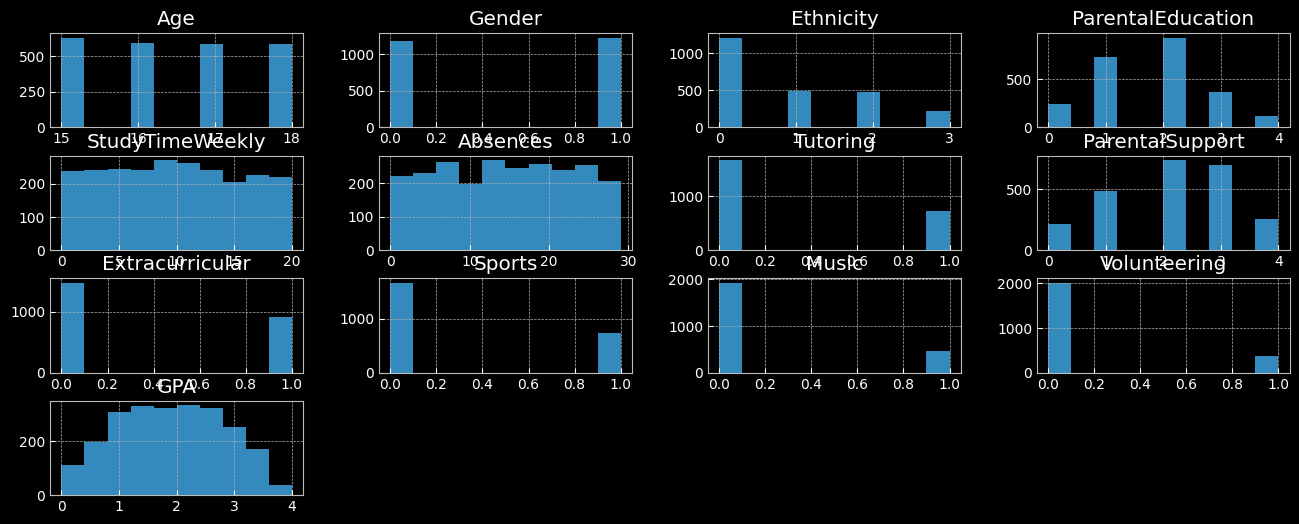

In [11]:
dataset.loc[:, dataset.columns != TARGET_FIELD].hist(figsize=(16, 6))
plt.show()

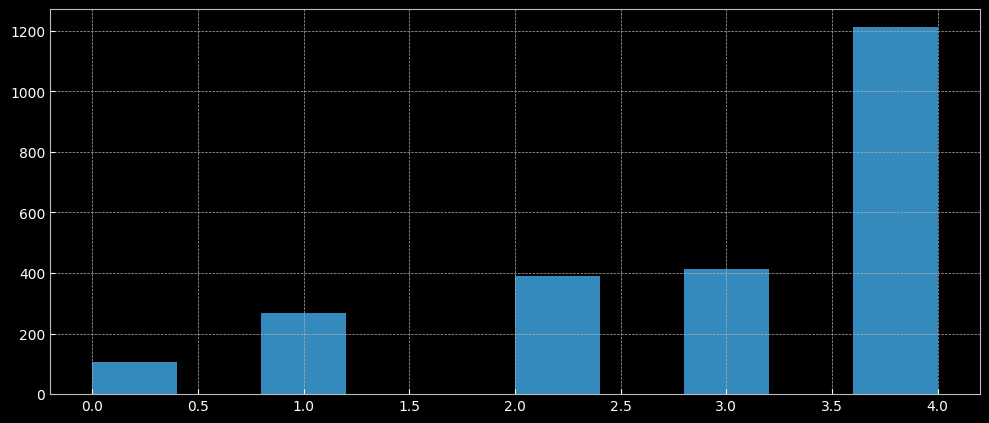

In [12]:
dataset[TARGET_FIELD].hist(figsize=(12, 5))
plt.show()

In [13]:
dataset[TARGET_FIELD].value_counts(normalize=True)

GradeClass
4    0.506271
3    0.173077
2    0.163462
1    0.112458
0    0.044732
Name: proportion, dtype: float64

### 2.2. Prepare dataset for modeling

In [14]:
# X = torch.FloatTensor(dataset.loc[:, dataset.columns != TARGET_FIELD].values).to(device)
# # y = torch.LongTensor(dataset[TARGET_FIELD].values).to(device)
# y = torch.LongTensor(dataset[TARGET_FIELD].values).to(device)


X = torch.from_numpy(dataset.loc[:, dataset.columns != TARGET_FIELD].to_numpy()).to(device, dtype = torch.float)
y = torch.from_numpy(dataset[TARGET_FIELD].to_numpy()).to(device, dtype = torch.long)

In [15]:
X.shape

torch.Size([2392, 13])

In [16]:
y.shape

torch.Size([2392])

## 3. Modeling

In [17]:
# Model params
LAMBDA_L2 = 0.00001
LR = 0.001
N_EPOCHS = 10000

In [18]:
# Prepare model params
model = torch.nn.Sequential(
    # Input layer
    torch.nn.Linear(13, 39),
    torch.nn.ReLU(),
    # Hiden Layer 1
    torch.nn.Linear(39, 24),
    torch.nn.Softmax(),
    # Hiden Layer 2
    torch.nn.Linear(24, 10),
    torch.nn.ReLU(),
    # Output Layer
    torch.nn.Linear(10, 5)
).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=LAMBDA_L2)
train_step = make_train_step(model, loss_fn, optimizer)
# Fit model
epoch_loss = []
for epoch in range(N_EPOCHS):
    loss = train_step(X, y)
    epoch_loss.append(loss)

/home/slava/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [19]:
print("Best model error:", loss)
print()
print("Model architecture:", model)
print()

Best model error: 0.3083118498325348

Model architecture: Sequential(
  (0): Linear(in_features=13, out_features=39, bias=True)
  (1): ReLU()
  (2): Linear(in_features=39, out_features=24, bias=True)
  (3): Softmax(dim=None)
  (4): Linear(in_features=24, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=5, bias=True)
)



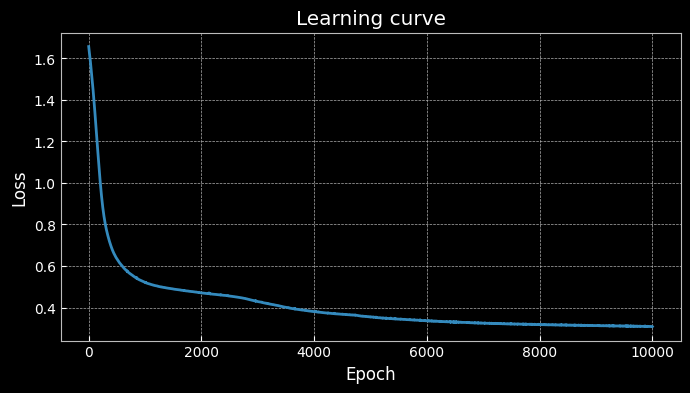

In [20]:
plot_learning_curve(epoch_loss)

К сожалению, мне не удалось запустить функцию `plot_model`.

Сверял мою выборку по формату с тем, что представлено в шаблоне кода, выяснил, что возникает ошибка при попытке умножения матрица.
Код сообщения об ошибке: 

`"RuntimeError: mat1 and mat2 shapes cannot be multiplied (48400x2 and 13x39)"`

Внёс правки в размерность матрицы в функции (чтоб она соответствовала кол-ву признаков в моём датасете, т.е. 13 признаков).

Код заработал, но визуализация, полагаю, не соответствует тому, чего ожидалось...

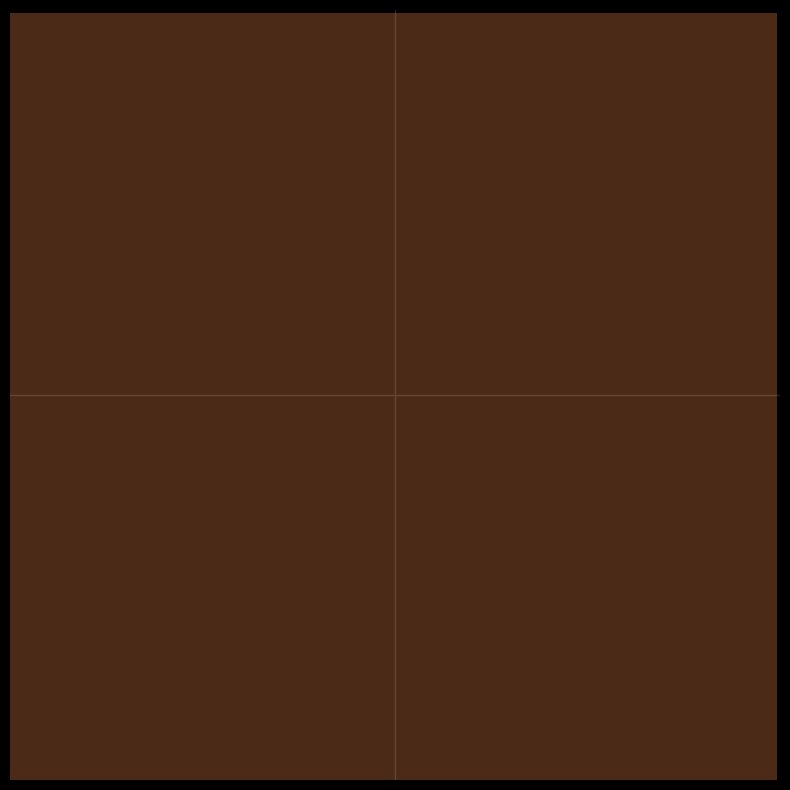

In [21]:
plot_model(X, y, model)